In [213]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import glob
import tqdm
import json
import optuna

import matplotlib.pyplot as pl
import tensorboardX as tb

np.random.seed(31337)

In [214]:
DATA_DIR = ""

In [215]:
data = pd.concat([
    pd.read_json(data_path, lines=True) 
    for data_path 
    in glob.glob(DATA_DIR + "/tmp/train_v_1.0/data.json")
])
data["rnd"] = np.random.random(len(data))


data

,message,timestamp,user,track,time,latency,recommendation,experiments,rnd
0,next,2024-04-14 13:52:50.811,6838,21235,1.00,0.001132,4529.0,{'AB': 'T1'},0.721852
1,next,2024-04-14 13:52:50.840,3169,8625,0.01,0.000943,2173.0,{'AB': 'T1'},0.966441
2,next,2024-04-14 13:52:50.843,5579,465,0.78,0.000927,0.0,{'AB': 'C'},0.289049
3,next,2024-04-14 13:52:50.845,8902,16494,0.00,0.000923,7971.0,{'AB': 'T1'},0.171346
4,next,2024-04-14 13:52:50.847,9367,22264,1.00,0.000781,46248.0,{'AB': 'T1'},0.371618
...,...,...,...,...,...,...,...,...,...
317065,next,2024-04-14 14:09:34.120,9254,3217,0.01,0.000628,68.0,{'AB': 'C'},0.056336
317066,next,2024-04-14 14:09:34.123,9254,68,0.01,0.000573,3571.0,{'AB': 'C'},0.060262
317067,next,2024-04-14 14:09:34.127,9254,3571,0.00,0.000927,4.0,{'AB': 'C'},0.906666
317068,next,2024-04-14 14:09:34.131,9254,4,0.00,0.000812,493.0,{'AB': 'C'},0.469956


In [216]:
positives = data[data["time"] > 0.7].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7
positives.drop_duplicates(["user", "track"], inplace=True)

In [217]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 0].index.values)

In [218]:
len(users)

9372

In [219]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 2].index.values)

In [220]:
len(users), len(tracks)

(9372, 4787)

## Train LightFM

In [221]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(73504, 29626)

In [222]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [223]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [224]:
def fit_model(
    epochs=1, 
    at=10,
    loss="warp",
    no_components=30,
    learning_rate=0.01, 
    max_sampled=10,
    user_alpha=0.0, 
    item_alpha=0.0, 
    threads=30, 
    verbose=False,
    patience=3,
    epsilon=1e-6,
):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
       
        
        # precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        
        # if verbose:
        #     print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
            
        # precisions_at.append(np.mean(precision_at))
            
        # if epoch > patience and all([precisions_at[-j] - precisions_at[-patience-1] < epsilon for j in range(1, patience + 1)]):
        #     if verbose:
        #         print("Early stopiing!")
        #     break
        
    # else:
    #     if verbose:
    #         print("No early stopiing happened: increase epochs maybe?")
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [225]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=10)
# best_params = study.best_params

In [226]:
best_params = {
    'no_components': 50,
    'loss': 'warp',
    'learning_rate': 0.0095,
    'max_sampled': 100,
    'user_alpha': 0.0,
    'item_alpha': 0.0,
}

In [227]:
model, precisions_at = fit_model(
    epochs=300,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

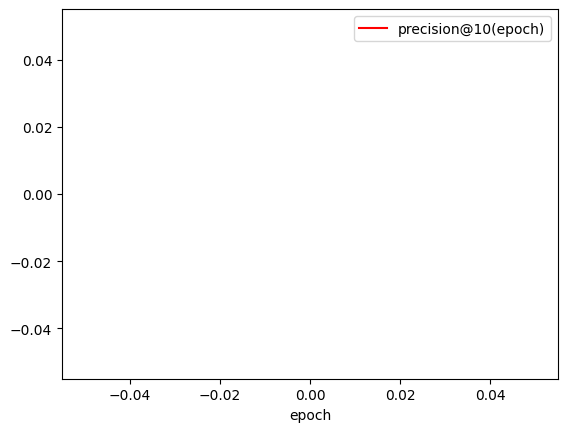

In [228]:
# TODO 1.4: Plot learning curve precision@k(epoch)
figure, ax = pl.subplots()

ax.plot(list(range(len(precisions_at))), precisions_at, "r", label="precision@10(epoch)")

ax.set_xlabel("epoch")
ax.legend()

pass

## Save track embeddings

In [229]:
BOTIFY_DATA_DIR = "/Users/lavrovseva/rec_sys_hw/recsys-course-spring-2024/botify/data/"

In [230]:
biases, embeddings = model.get_item_representations()

In [231]:
model.item_biases *= 0.0

In [232]:
track_meta = pd.read_json(BOTIFY_DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [233]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [234]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [235]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [236]:
with open(BOTIFY_DATA_DIR + "recommendations_mar.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-30:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": [int(x) for x in top]
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|██████████| 9372/9372 [00:07<00:00, 1222.22it/s]
